In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam

RANDOM_SEED = 1
torch.manual_seed(RANDOM_SEED)

In [2]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=10):
        super(CNNModel, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )

        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.conv_layer11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.conv_layer12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)
        )

        self.flatten = nn.Flatten()

        self.fc_layer1 = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512),
            nn.ReLU()
        )
        self.fc_layer2 = nn.Linear(512, n_classes)
    
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = self.conv_layer11(x)
        x = self.conv_layer12(x)
        x = self.flatten(x)
        x = self.fc_layer1(x)
        out = self.fc_layer2(x)

        return out

In [3]:
n_classes = 10
n_epochs = 50
batch_size = 256
lr = 1e-4

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

train_dataloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_dataloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNModel(n_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)  

training_steps = len(train_dataloader)
val_steps = len(val_dataloader)

training_losses = []
val_losses = []

val_accs = []

print('Start Training...\n')
for epoch in range(n_epochs):
    total_training_loss = 0
    model.train()
    for idx, (X_train, y_train) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        total_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_loss = total_training_loss / training_steps
    training_losses.append(training_loss)

    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {training_loss:.3f}')

    with torch.no_grad():
        model.eval()
        n_correct_preds = 0
        n_val_samples = 0
        total_val_loss = 0
        for idx, (X_val, y_val) in enumerate(val_dataloader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            total_val_loss += loss.item()

            y_pred_max, y_pred_max_idx = torch.max(y_pred, 1)
            n_val_samples += y_pred.size(0)
            n_correct_preds += (y_val == y_pred_max_idx).sum().item()

        val_acc = n_correct_preds / n_val_samples
        val_loss = total_val_loss / val_steps
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.3f}\n')

print('Training Completed')

Start Training...

Epoch [1/50], Training Loss: 1.300
Val Loss: 1.025, Val Accuracy: 0.632

Epoch [2/50], Training Loss: 0.829
Val Loss: 0.899, Val Accuracy: 0.684

Epoch [3/50], Training Loss: 0.572
Val Loss: 0.812, Val Accuracy: 0.720

Epoch [4/50], Training Loss: 0.372
Val Loss: 0.809, Val Accuracy: 0.740

Epoch [5/50], Training Loss: 0.213
Val Loss: 0.976, Val Accuracy: 0.725

Epoch [6/50], Training Loss: 0.139
Val Loss: 0.970, Val Accuracy: 0.744

Epoch [7/50], Training Loss: 0.112
Val Loss: 1.039, Val Accuracy: 0.744

Epoch [8/50], Training Loss: 0.096
Val Loss: 1.054, Val Accuracy: 0.753

Epoch [9/50], Training Loss: 0.084
Val Loss: 1.111, Val Accuracy: 0.752

Epoch [10/50], Training Loss: 0.067
Val Loss: 1.102, Val Accuracy: 0.755

Epoch [11/50], Training Loss: 0.058
Val Loss: 1.111, Val Accuracy: 0.766

Epoch [12/50], Training Loss: 0.064
Val Loss: 1.238, Val Accuracy: 0.753

Epoch [13/50], Training Loss: 0.069
Val Loss: 1.171, Val Accuracy: 0.762

Epoch [14/50], Training Loss

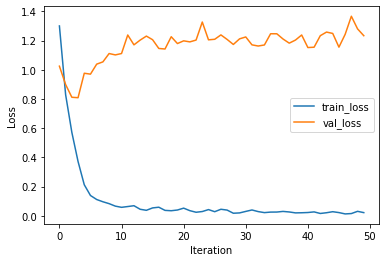

In [6]:
plt.plot(training_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()